In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.models import Model, model_from_json
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.model_selection import KFold

from tqdm import tqdm
from tqdm import trange

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import numpy as np

from matplotlib.gridspec import GridSpec

## Convolutional neural network classification

In the third part of the project you will use a simple convolutional neural network to perform the classification of the digits data set using Tensorflow and Keras.

#### (a) Building a simple convolutional neural network model 
Build and train a simple convolutional neural network model (of one or two convolutional layers) to classify the images in the digits data set. Evaluate its performance.

#### (b) Investigating the CNN performance
Investigate the performance of the convolutional neural network in terms of the size of the training data and the design of the layers. Try to find a network with as fewparameters as possible, without sacrificing performance.
> **Note:** A useful tutorial on buildinga simple convolutional neural network for classifying the mnist data set is available at https://www.tensorflow.org/tutorials/.

## Loading and reshaping the input dataset

The images (8px x 8px) has been stocked into pandas dataframe as 1D vectors of 64 values. We reshape all data to 8x8 matrices. PyTorch requires an extra dimension in the beginning, which correspond to channels. Handwritten digits are gray scaled so it use only one channel (note that for RGB images, there are 3 channels).

In [12]:
''' Load data into train set and test set '''
def load_dataset(prop):
    digits = datasets.load_digits()
    # Create the features matrix
    data = digits.data
    # Create the target vector
    lables = digits.target

    # Every pixel in the images takes a value between 0 and 255. 
    # It is often a good idea to normilize the data between 0 and 1.
    data = data[:,:,np.newaxis].astype('float32')/255.0

    # Create training and test sets
    X_train, X_test, y_train, y_test = train_test_split(data, 
                                                        lables, 
                                                        test_size=prop, 
                                                        random_state=42)

    return data, lables, X_train, X_test, y_train, y_test

In [120]:
data, lables, X_train, X_test, y_train, y_test = load_dataset(0.25)
# Summarize loaded dataset
print(data.shape)
print('Train dataset: X = %s, y = %s' % (X_train.shape, y_train.shape))
print('Test dataset:  X = %s,  y = %s' % (X_test.shape, y_test.shape))
pic_size = X_train.shape[1]
img_rows = np.sqrt(pic_size).astype('int')
img_cols = img_rows

(1797, 64, 1)
Train dataset: X = (1347, 64, 1), y = (1347,)
Test dataset:  X = (450, 64, 1),  y = (450,)


## Plotting the input dataset and checking is it balanced

C:\Users\Anna\Anaconda3\envs\Networks\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


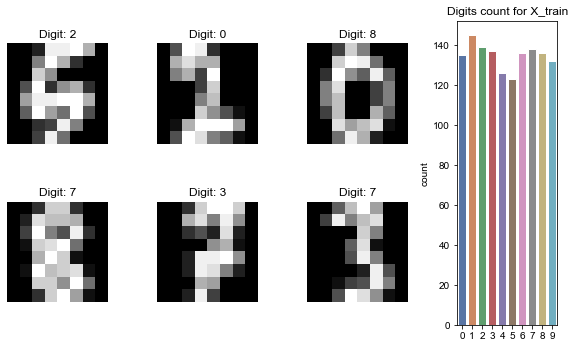

In [14]:
fig = plt.figure(figsize=(8, 5))
nrows=2
ncols=4
gs = GridSpec(nrows, ncols)
count = 0
for row in range(nrows):
    for col in range(ncols-1):
        ax = fig.add_subplot(gs[row, col])
        plt.imshow(X_train[count].reshape((img_rows, img_cols)),cmap = "gray")
        count += 1
        plt.title("Digit: {}".format(y_train[count]))
        plt.axis('off')

ax2 = fig.add_subplot(gs[:, ncols-1])
sns.set_theme(style="darkgrid")
sns.countplot(y_train)
plt.title('Digits count for X_train')
plt.tight_layout()
plt.show()

In [15]:
def evaluate(model, epochs, batch_size, X, y, n_folds=5):
	''' Fuction for a model evaluation using 5-fold cross-validation '''
	scores, histories = [], []
	# Prepare cross-validation
	kfold = KFold(n_folds, shuffle=True, random_state=1)
	# Enumerate splits
	for train_ix, test_ix in kfold.split(X):
		# Select rows for train and test
		X_train, y_train, X_test, y_test = X[train_ix], y[train_ix], X[test_ix], y[test_ix]
		# Fit model
		history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose = 0)
		# Evaluate model
		_, acc = model.evaluate(X_test, y_test, verbose=0)
		# Store scores
		scores.append(acc)
		histories.append(history)
	return scores, histories


def diagnostics(fold_histories, histories):
	fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (8,4))
	''' Diagnostics of the model learning behavior during training and the estimation of the model performance '''
	# Plotting a loss-finction
	ax1.set_title('Loss (train/test split)')
	ax1.plot(histories.history['loss'], color='orange', label='Train')
	ax1.plot(histories.history['val_loss'], color='green', label='Test')
	ax1.legend()
	# Plotting accuracy
	ax2.set_title('Classification Accuracy (train/test split)')
	ax2.plot(histories.history['accuracy'], color='orange')
	ax2.plot(histories.history['val_accuracy'], color='green')
	ax2.set_ylim(0.4, 1.)
	fig.tight_layout()
	# fig.savefig('finaltest.pdf')
	fig.show()
	
	plt.figure(figsize=(8,8))
	for i in range(len(fold_histories)):
		# Plotting a loss-finction
		plt.subplot(2, 2, 1)
		plt.title('Loss (k-fold)')
		plt.plot(fold_histories[i].history['loss'], color='orange', label='Train')
		plt.plot(fold_histories[i].history['val_loss'], color='green', label='Test')
		# Plotting accuracy
		plt.subplot(2, 2, 2)
		plt.title('Classification Accuracy (k-fold)')
		plt.plot(fold_histories[i].history['accuracy'], color='orange')
		plt.plot(fold_histories[i].history['val_accuracy'], color='green')
	plt.tight_layout()
	# fig.savefig('finaltestfold.pdf')
	plt.show()

	return 

def scoreTest(kFold_accScores,acc_score):
	print('Average Accuracy Score on k-Fold Cross Validation:  %.3f' % (np.mean(kFold_accScores)))
	print('Accuracy Score on k-Fold Cross Validation:')
	for i in range(len(kFold_accScores)):
		print(f'{i+1}-Fold:  %.3f' % (kFold_accScores[i]))
	print('Accuracy Score on a Test Dataset:  %.3f' % (acc_score))
	return

## Building the one-layer (RElu) CNN - model 1

In [360]:
# define both batch_size and epochs
batch_size, epochs = 32, 100

inputs = keras.Input(shape=(pic_size,1))
fl = Flatten()(inputs)
hiddenLayer1 = Dense(1000, activation = 'relu')(fl)
# hiddenLayer1 = Dense(1000, activation = 'relu', kernel_initializer='he_uniform')(inputs)
outputs = Dense(10, activation = 'softmax')(hiddenLayer1)

oneHiddenLayerModel = Model(inputs, outputs,name = "dense_deep")
opt = SGD(learning_rate = 0.01)
# opt = SGD(learning_rate = 0.01, momentum=0.9)
oneHiddenLayerModel.compile(optimizer = opt, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

# Evaluate the model using 5-fold validation
kFold_accScores, kFold_History = evaluate(oneHiddenLayerModel, epochs, batch_size, data, lables, n_folds=5)
# Evaluating model on a test set 
hist = oneHiddenLayerModel.fit(X_train, y_train, batch_size = batch_size, epochs = epochs, validation_data=(X_test,y_test),verbose = 0)
_,acc_score = oneHiddenLayerModel.evaluate(X_test, y_test, verbose=0)

oneHiddenLayerModel.summary()

Model: "dense_deep"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_66 (InputLayer)       [(None, 64, 1)]           0         
                                                                 
 flatten_36 (Flatten)        (None, 64)                0         
                                                                 
 dense_151 (Dense)           (None, 1000)              65000     
                                                                 
 dense_152 (Dense)           (None, 10)                10010     
                                                                 
Total params: 75,010
Trainable params: 75,010
Non-trainable params: 0
_________________________________________________________________


Average Accuracy Score on k-Fold Cross Validation:  0.829
Accuracy Score on k-Fold Cross Validation:
1-Fold:  0.794
2-Fold:  0.814
3-Fold:  0.783
4-Fold:  0.861
5-Fold:  0.891
Accuracy Score on a Test Dataset:  0.913


C:\Users\Anna\Anaconda3\envs\Networks\lib\site-packages\ipykernel_launcher.py:35: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


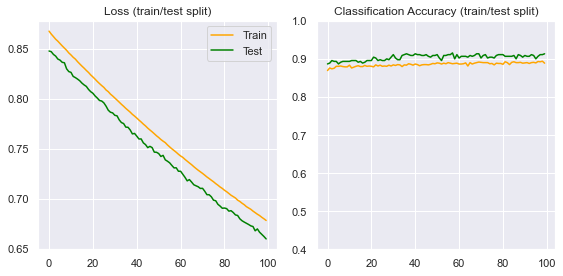

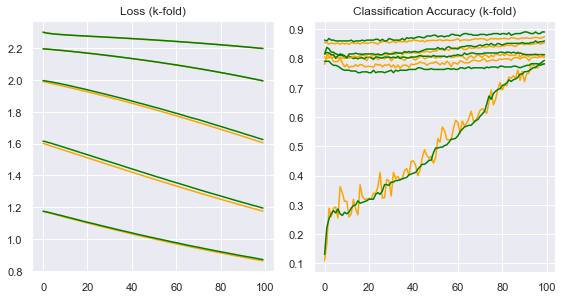

In [391]:
scoreTest(kFold_accScores, acc_score)
diagnostics(kFold_History, hist)

## Building an upgraded one-layer (RElu) CNN - model 2

In [403]:
# define both batch_size and epochs
batch_size, epochs = 32, 100

inputs = keras.Input(shape=(pic_size,1))
fl = Flatten()(inputs)
# hiddenLayer1 = Dense(1000, activation = 'relu')(fl)
hiddenLayer1 = Dense(1000, activation = 'relu', kernel_initializer='he_uniform')(fl)
outputs = Dense(10, activation = 'softmax')(hiddenLayer1)

oneHiddenLayerModelupg = Model(inputs, outputs,name = "dense_deep")
# opt = SGD(learning_rate = 0.01)
opt = SGD(learning_rate = 0.01, momentum=0.9)
oneHiddenLayerModelupg.compile(optimizer = opt, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

# Evaluate the model using 5-fold validation
kFold_accScores2, kFold_History2 = evaluate(oneHiddenLayerModelupg, epochs, batch_size, data, lables, n_folds=5)
# Evaluating model on a test set 
hist2 = oneHiddenLayerModelupg.fit(X_train, y_train, batch_size = batch_size, epochs = epochs, validation_data=(X_test,y_test),verbose = 0)
_,acc_score2 = oneHiddenLayerModelupg.evaluate(X_test, y_test, verbose=0)

oneHiddenLayerModelupg.summary()

Model: "dense_deep"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_70 (InputLayer)       [(None, 64, 1)]           0         
                                                                 
 flatten_40 (Flatten)        (None, 64)                0         
                                                                 
 dense_162 (Dense)           (None, 1000)              65000     
                                                                 
 dense_163 (Dense)           (None, 10)                10010     
                                                                 
Total params: 75,010
Trainable params: 75,010
Non-trainable params: 0
_________________________________________________________________


Average Accuracy Score on k-Fold Cross Validation:  0.964
Accuracy Score on k-Fold Cross Validation:
1-Fold:  0.942
2-Fold:  0.953
3-Fold:  0.978
4-Fold:  0.983
5-Fold:  0.964
Accuracy Score on a Test Dataset:  0.982


C:\Users\Anna\Anaconda3\envs\Networks\lib\site-packages\ipykernel_launcher.py:35: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


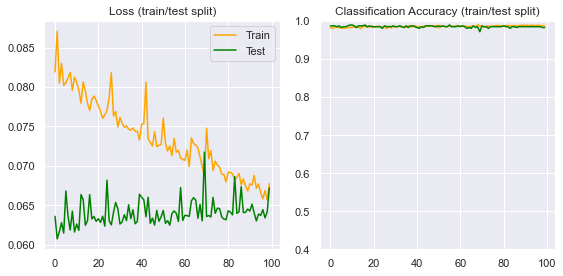

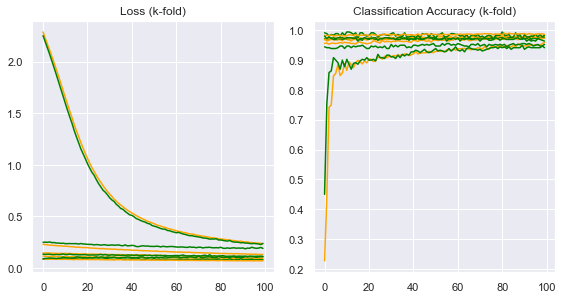

In [408]:
'''Much better accuracy results; however, with train and test learning curves do not converge'''
scoreTest(kFold_accScores2, acc_score2)
diagnostics(kFold_History2, hist2)

## Building a milti-layer NN - model 3

In [409]:
# define both batch_size and epochs
batch_size, epochs = 32, 100

inputs_deep = keras.Input(shape=(pic_size,1))
fl = Flatten()(inputs_deep)
hidden_1 = Dense(1000,activation = 'relu')(fl)
hidden_2 = Dense(500, activation = 'relu')(hidden_1)
hidden_3 = Dense(100, activation = 'relu')(hidden_2)
hidden_4 = Dense(50, activation = 'relu')(hidden_3)
outputs_deep = Dense(10, activation = 'softmax')(hidden_4)
model_deep = Model(inputs_deep, outputs_deep,name = "dense_deep")
# opt = Adam()
opt = SGD(learning_rate = 0.01)
model_deep.compile(optimizer = opt, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

# Evaluate the model using 5-fold validation
kFold_accScores3, kFold_History3 = evaluate(model_deep, epochs, batch_size, data, lables, n_folds=5)
# Evaluating model on a test set 
hist3 = model_deep.fit(X_train, y_train, batch_size = batch_size, epochs = epochs, validation_data=(X_test,y_test),verbose = 0)
_,acc_score3 = model_deep.evaluate(X_test, y_test, verbose=0)

model_deep.summary()

Model: "dense_deep"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_72 (InputLayer)       [(None, 64, 1)]           0         
                                                                 
 flatten_42 (Flatten)        (None, 64)                0         
                                                                 
 dense_169 (Dense)           (None, 1000)              65000     
                                                                 
 dense_170 (Dense)           (None, 500)               500500    
                                                                 
 dense_171 (Dense)           (None, 100)               50100     
                                                                 
 dense_172 (Dense)           (None, 50)                5050      
                                                                 
 dense_173 (Dense)           (None, 10)                5

Average Accuracy Score on k-Fold Cross Validation:  0.916
Accuracy Score on k-Fold Cross Validation:
1-Fold:  0.836
2-Fold:  0.847
3-Fold:  0.953
4-Fold:  0.975
5-Fold:  0.969
Accuracy Score on a Test Dataset:  0.973


C:\Users\Anna\Anaconda3\envs\Networks\lib\site-packages\ipykernel_launcher.py:35: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


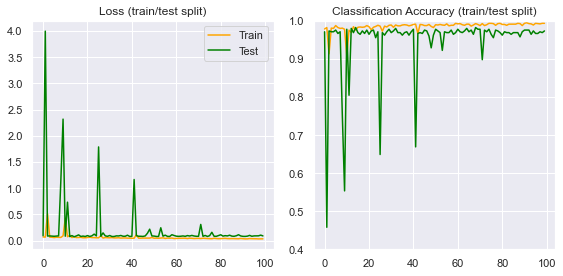

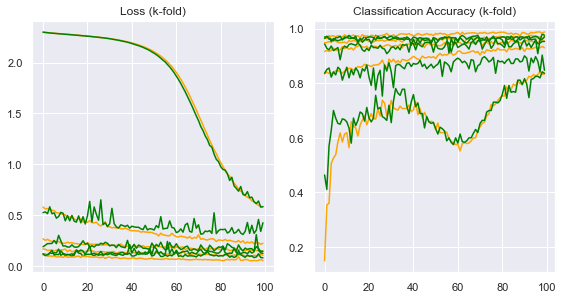

In [411]:
scoreTest(kFold_accScores3, acc_score3)
diagnostics(kFold_History3, hist3)

## Building a convolutional milti-layer CNN (less parameters example) - model 4

In [121]:
data_shaped = np.reshape(data, (data.shape[0], img_rows, img_cols,1))
X_train_shaped = np.reshape(X_train, (X_train.shape[0], img_rows, img_cols,1))
X_test_shaped = np.reshape(X_test, (X_test.shape[0], img_rows, img_cols, 1))

In [122]:
inputs_cnn = Input(shape = (8,8,1))
cnn_1 = Conv2D(filters = 4, padding='same',kernel_size = 3, strides = (1,1),activation = 'relu')(inputs_cnn)
dr_1 = Dropout(0.1)(cnn_1)
cnn_2 = Conv2D(filters = 8, padding='same',kernel_size = 3, strides = (1,1),activation = 'relu')(dr_1)
mp_1 = MaxPool2D(pool_size= 2)(cnn_2)
dr_2 = Dropout(0.1)(mp_1)

cnn_3 = Conv2D(filters = 16, padding='same',kernel_size = 3, strides = (1,1),activation = 'relu')(dr_2)
dr_3 = Dropout(0.1)(cnn_3)
# cnn_4 = Conv2D(filters = 64, padding='same',kernel_size = 3, strides = (1,1),activation = 'relu')(dr_3)
# mp_2 = MaxPool2D(pool_size= 2)(cnn_4)
# dr_4 = Dropout(0.1)(mp_2)
fl= Flatten()(dr_3)
hidden_1 = Dense(100, activation = 'relu', kernel_initializer='he_uniform')(fl)
hidden_2 = Dense(50, activation = 'relu', kernel_initializer='he_uniform')(hidden_1)
output_cnn = Dense(10, activation = 'softmax')(hidden_2)

model_cnn = Model(inputs_cnn, output_cnn)
opt = Adam()
model_cnn.compile(optimizer = opt, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model_cnn.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 8, 8, 1)]         0         
                                                                 
 conv2d_9 (Conv2D)           (None, 8, 8, 4)           40        
                                                                 
 dropout_9 (Dropout)         (None, 8, 8, 4)           0         
                                                                 
 conv2d_10 (Conv2D)          (None, 8, 8, 8)           296       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 4, 4, 8)          0         
 2D)                                                             
                                                                 
 dropout_10 (Dropout)        (None, 4, 4, 8)           0         
                                                           

In [123]:
# define both batch_size and epochs
batch_size, epochs = 32, 100
# Evaluate the model using 5-fold validation
kFold_accScores4, kFold_History4 = evaluate(model_cnn, epochs, batch_size, data_shaped, lables, n_folds=5)
# Evaluating model on a test set 
hist4 = model_cnn.fit(X_train_shaped, y_train, batch_size = batch_size, epochs = epochs, validation_data=(X_test_shaped,y_test),verbose = 0)
_,acc_score4 = model_cnn.evaluate(X_test_shaped, y_test, verbose=0)

Average Accuracy Score on k-Fold Cross Validation:  0.992
Accuracy Score on k-Fold Cross Validation:
1-Fold:  0.983
2-Fold:  0.983
3-Fold:  0.997
4-Fold:  0.997
5-Fold:  1.000
Accuracy Score on a Test Dataset:  0.998


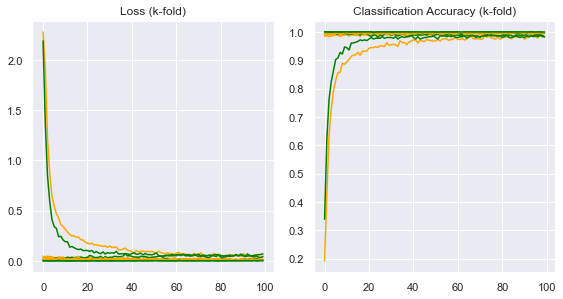

In [22]:
# model_cnn.summary()
scoreTest(kFold_accScores4, acc_score4)
diagnostics(kFold_History4, hist4)

## Building a convolutional milti-layer CNN (other examples with larger set of parameters) 

Average Accuracy Score on k-Fold Cross Validation:  0.977
Accuracy Score on k-Fold Cross Validation:
1-Fold:  0.953
2-Fold:  0.958
3-Fold:  0.983
4-Fold:  0.997
5-Fold:  0.992
Accuracy Score on a Test Dataset:  0.996


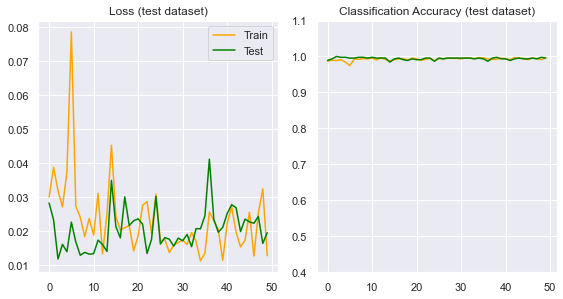

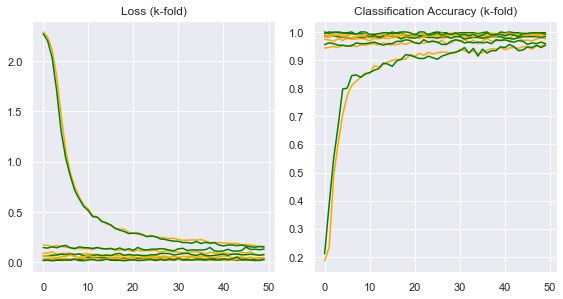

In [333]:
# Does not have a great performance

inputs_cnn = Input(shape = (img_rows,img_cols,1))
cnn_1 = Conv2D(filters = 4, padding='same',kernel_size = 3, strides = (1,1), activation = 'relu')(inputs_cnn)
dr_1 = Dropout(0.1)(cnn_1)
mp_1 = MaxPool2D(pool_size= 2)(dr_1)
fl= Flatten()(mp_1)
hidden_1 = Dense(100, activation = 'relu', kernel_initializer='he_uniform')(fl)
hidden_2 = Dense(50, activation = 'relu', kernel_initializer='he_uniform')(hidden_1)
output_cnn = Dense(10, activation = 'softmax')(hidden_2)

model_cnn0 = Model(inputs_cnn, output_cnn)
opt = Adam()
model_cnn0.compile(optimizer = opt, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

# define both batch_size and epochs
batch_size, epochs = 32, 50
# Evaluate the model using 5-fold validation
kFold_accScores5, kFold_History5 = evaluate(model_cnn0, epochs, batch_size, data_shaped, lables, n_folds=5)
# Evaluating model on a test set 
hist5 = model_cnn0.fit(X_train_shaped, y_train, batch_size = batch_size, epochs = epochs, validation_data=(X_test_shaped,y_test),verbose = 0)
_,acc_score5 = model_cnn0.evaluate(X_test_shaped, y_test, verbose=0)

scoreTest(kFold_accScores5, acc_score5)
diagnostics(kFold_History5, hist5)


In [446]:
inputs_cnn = Input(shape = (img_rows,img_cols,1))
cnn_1 = Conv2D(filters = 4, padding='same',kernel_size = 3, strides = (1,1), activation = 'relu')(inputs_cnn)
mp_1 = MaxPool2D(pool_size= 2)(cnn_1)
dr_1 = Dropout(0.1)(mp_1)
cnn_2 = Conv2D(filters = 8, padding='same', kernel_size = 3, strides = (1,1), activation = 'relu')(dr_1)
mp_2 = MaxPool2D(pool_size= 2)(cnn_2)
fl= Flatten()(mp_2)
hidden_1 = Dense(500, activation = 'relu', kernel_initializer='he_uniform')(fl)
output_cnn = Dense(10, activation = 'softmax')(hidden_1)

model_cnn1 = Model(inputs_cnn, output_cnn)
opt = Adam()
model_cnn1.compile(optimizer = opt, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

# define both batch_size and epochs
batch_size, epochs = 32, 100
# Evaluate the model using 5-fold validation
kFold_accScores5, kFold_History5 = evaluate(model_cnn1, epochs, batch_size, data_shaped, lables, n_folds=5)
# Evaluating model on a test set 
hist5 = model_cnn1.fit(X_train_shaped, y_train, batch_size = batch_size, epochs = epochs, validation_data=(X_test_shaped,y_test),verbose = 0)
_,acc_score5 = model_cnn1.evaluate(X_test_shaped, y_test, verbose=0)

Model: "model_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_88 (InputLayer)       [(None, 8, 8, 1)]         0         
                                                                 
 conv2d_118 (Conv2D)         (None, 8, 8, 4)           40        
                                                                 
 max_pooling2d_66 (MaxPoolin  (None, 4, 4, 4)          0         
 g2D)                                                            
                                                                 
 dropout_89 (Dropout)        (None, 4, 4, 4)           0         
                                                                 
 conv2d_119 (Conv2D)         (None, 4, 4, 8)           296       
                                                                 
 flatten_58 (Flatten)        (None, 128)               0         
                                                          

C:\Users\Anna\Anaconda3\envs\Networks\lib\site-packages\ipykernel_launcher.py:35: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


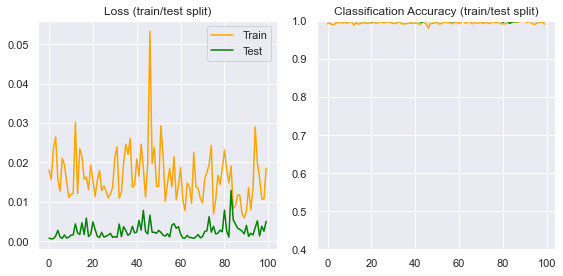

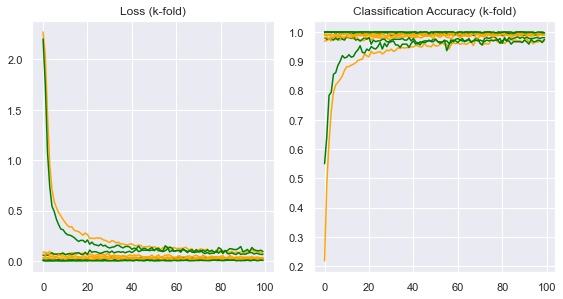

In [449]:
model_cnn1.summary()
scoreTest(kFold_accScores5, acc_score5)
diagnostics(kFold_History5, hist5)

#### Addition CNN Model - the best performance we obtained over training, although the loss function does not look great

In [441]:
inputs_cnn = Input(shape = (img_rows,img_cols,1))
cnn_1 = Conv2D(filters = 8, padding='same',kernel_size = 3, strides = (1,1), activation = 'relu')(inputs_cnn)
mp_1 = MaxPool2D(pool_size= 2)(cnn_1)
dr_1 = Dropout(0.1)(mp_1)
cnn_2 = Conv2D(filters = 16, padding='same', kernel_size = 3, strides = (1,1), activation = 'relu')(dr_1)
fl= Flatten()(cnn_2)
hidden_1 = Dense(100, activation = 'relu', kernel_initializer='he_uniform')(fl)
hidden_2 = Dense(50, activation = 'relu', kernel_initializer='he_uniform')(hidden_1)
output_cnn = Dense(10, activation = 'softmax')(hidden_2)

model_cnn2 = Model(inputs_cnn, output_cnn)
opt = Adam()
model_cnn2.compile(optimizer = opt, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

# define both batch_size and epochs
batch_size, epochs = 32, 100
# Evaluate the model using 5-fold validation
kFold_accScores6, kFold_History6 = evaluate(model_cnn2, epochs, batch_size, data_shaped, lables, n_folds=5)
# Evaluating model on a test set 
hist6 = model_cnn2.fit(X_train_shaped, y_train, batch_size = batch_size, epochs = epochs, validation_data=(X_test_shaped,y_test),verbose = 0)
_,acc_score6 = model_cnn2.evaluate(X_test_shaped, y_test, verbose=0)

Average Accuracy Score on k-Fold Cross Validation:  0.995
Accuracy Score on k-Fold Cross Validation:
1-Fold:  0.992
2-Fold:  0.989
3-Fold:  0.997
4-Fold:  1.000
5-Fold:  0.997
Accuracy Score on a Test Dataset:  1.000


C:\Users\Anna\Anaconda3\envs\Networks\lib\site-packages\ipykernel_launcher.py:35: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


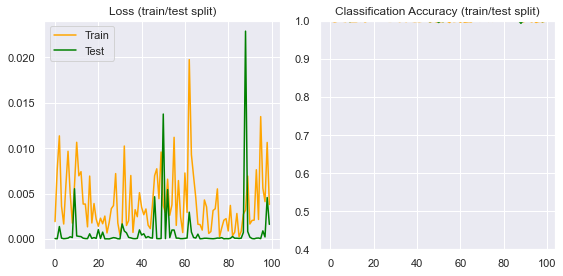

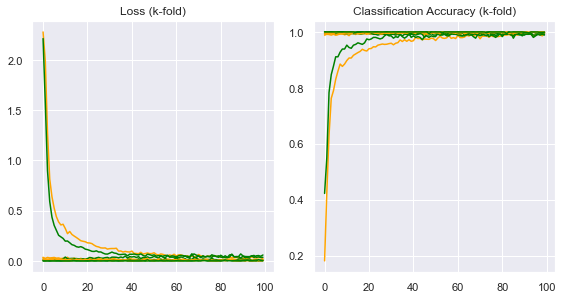

In [453]:
# model_cnn2.summary()
scoreTest(kFold_accScores6, acc_score6)
diagnostics(kFold_History6, hist6)

## Train/test splitting analysis

In [70]:
arr_prop = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
hist = []
acc_score = []

for i, prop in enumerate(arr_prop):
    data, lables, X_train, X_test, y_train, y_test = load_dataset(prop)
    data_shaped = np.reshape(data, (data.shape[0], img_rows, img_cols,1))
    X_train_shaped = np.reshape(X_train, (X_train.shape[0], img_rows, img_cols,1))
    X_test_shaped = np.reshape(X_test, (X_test.shape[0], img_rows, img_cols, 1))
    # Evaluating model on a test set 
    hist.append(model_cnn.fit(X_train_shaped, y_train, batch_size = batch_size, epochs = epochs, validation_data=(X_test_shaped,y_test),verbose = 0))
    _,acc_score_cur = model_cnn.evaluate(X_test_shaped, y_test, verbose=0)
    acc_score.append(acc_score_cur)

Accuracy Score on a Test Dataset 0.989
Accuracy Score on a Test Dataset 0.997
Accuracy Score on a Test Dataset 0.996
Accuracy Score on a Test Dataset 0.997
Accuracy Score on a Test Dataset 0.999
Accuracy Score on a Test Dataset 0.998


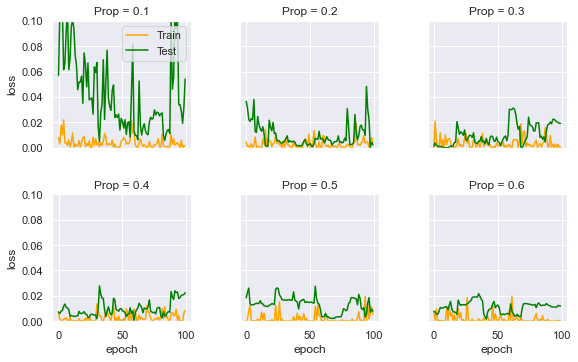

In [71]:
for i in range(len(arr_prop)):
    print('Accuracy Score on a Test Dataset %.3f' % (acc_score[i]))

fig, axs = plt.subplots(2, 3, figsize = (8,5))
axs[0, 0].plot(hist[0].history['loss'], color='orange', label='Train')
axs[0, 0].plot(hist[0].history['val_loss'], color='green', label='Test')
axs[0, 0].set_ylim(0,0.1)
axs[0, 0].legend()
axs[0, 0].set_title('Prop = 0.1')
axs[0, 1].plot(hist[1].history['loss'], color='orange', label='Train')
axs[0, 1].plot(hist[1].history['val_loss'], color='green', label='Test')
axs[0, 1].set_ylim(0,0.1)
axs[0, 1].set_title('Prop = 0.2')
axs[0, 2].plot(hist[2].history['loss'], color='orange', label='Train')
axs[0, 2].plot(hist[2].history['val_loss'], color='green', label='Test')
axs[0, 2].set_ylim(0,0.1)
axs[0, 2].set_title('Prop = 0.3')
axs[1, 0].plot(hist[3].history['loss'], color='orange', label='Train')
axs[1, 0].plot(hist[3].history['val_loss'], color='green', label='Test')
axs[1, 0].set_title('Prop = 0.4')
axs[1, 0].set_ylim(0,0.1)
axs[1, 1].plot(hist[4].history['loss'], color='orange', label='Train')
axs[1, 1].plot(hist[4].history['val_loss'], color='green', label='Test')
axs[1, 1].set_title('Prop = 0.5')
axs[1, 1].set_ylim(0,0.1)
axs[1, 2].plot(hist[5].history['loss'], color='orange', label='Train')
axs[1, 2].plot(hist[5].history['val_loss'], color='green', label='Test')
axs[1, 2].set_ylim(0,0.1)
axs[1, 2].set_title('Prop = 0.6')
fig.tight_layout()
fig.savefig('losssplit.pdf')

for ax in axs.flat:
    ax.set(xlabel='epoch', ylabel='loss')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()




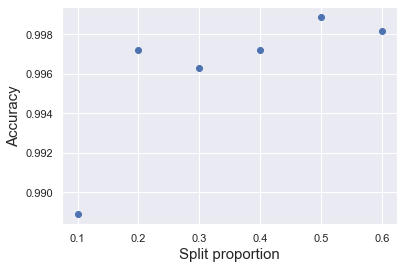

In [72]:
plt.scatter(arr_prop, acc_score, marker='o')
plt.xlabel(r'Split proportion', fontsize=15)
plt.ylabel(r'Accuracy', fontsize=15)
plt.savefig('Split.pdf')
plt.show()

## Prediction analysis

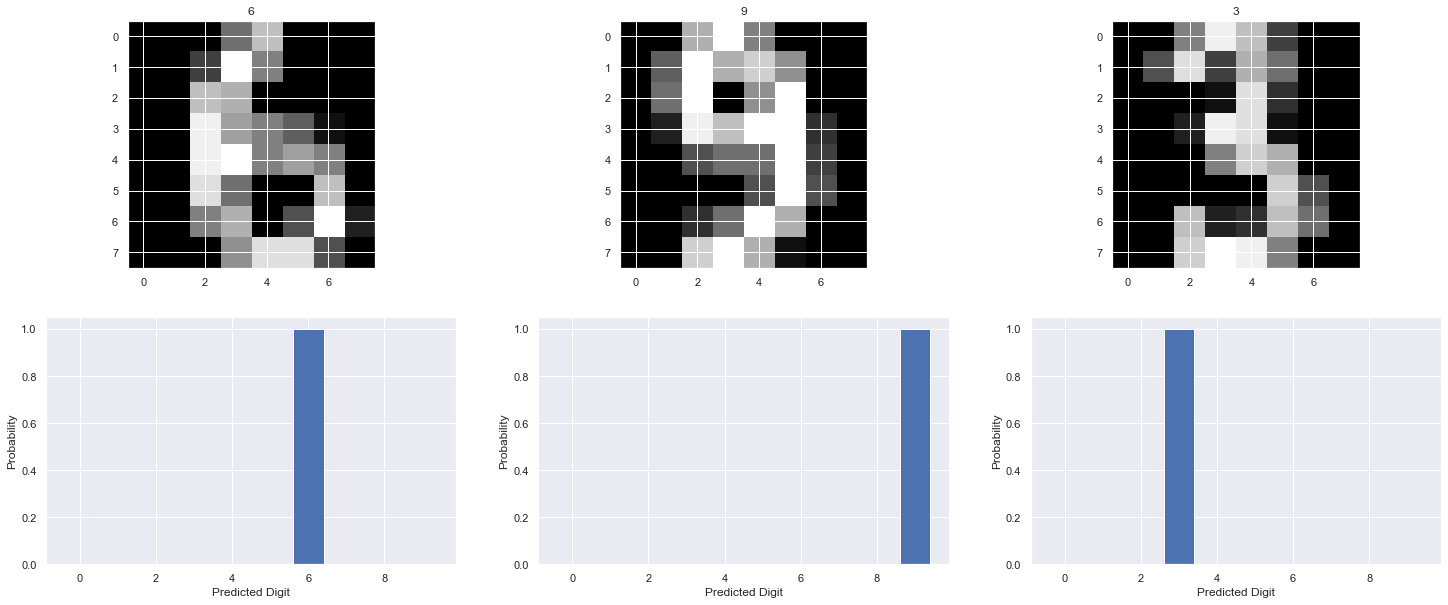

In [93]:
y_pred = model_cnn.predict(X_test_shaped[0:3])
plt.figure(figsize= (25,10))
class_labels = list(range(0, 10))

for i in range(3):
    plt.subplot(2,3,i+1)
    plt.imshow(X_test_shaped[i].reshape((8,8)),cmap='gray')
    plt.title(y_test[i])
    plt.subplot(2,3,i+4)
    plt.bar(class_labels,y_pred[i])
    plt.xlabel('Predicted Digit')
    plt.ylabel('Probability')